# pyburst demonstration

In [1]:
import math
import numpy
import matplotlib.pyplot as plt
import pyburst as pb
import pyburst.detectors, pyburst.cbc, pyburst.timefreq, pyburst.skymaps
import lal
import gwpy
from gwpy.timeseries import TimeSeries
import gwpy.signal
import healpy

In [2]:
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['figure.titlesize'] = 'medium'

## Define detector network

In [3]:
detectors = ['H1', 'L1', 'V1']
network = [pb.detectors.Detector(d) for d in detectors]

## Define sky grid

In [5]:
NSIDE = 16
sky = pb.skymaps.Skymap(NSIDE, 'geographic', order='nested')

## Compute antenna pattern over the sky grid

In [6]:
antenna_patterns = numpy.array([d.antenna_pattern(sky.grid_points()) for d in network])  

## Compute propagation delays over the sky grid

In [7]:
delays = numpy.array([d.time_delay_from_earth_center(sky.grid_points()) for d in network])

## Seek data from local files

In [22]:
#gps = 1187008887
gps = 1186741851 # 10 sec before event
offset = +5
segment = (int(gps + offset)-5, int(gps + offset)+5)
print(segment)

datafolder = '../../HLV-data'
#datafiles = ['H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5', \
#            'L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5', \
#            'V-V1_LOSC_CLN_4_V1-1187007040-2048.hdf5']
datafiles = ['H-H1_LOSC_CLN_4_V1-1186741845-32.hdf5', \
            'L-L1_LOSC_CLN_4_V1-1186741845-32.hdf5', \
            'V-V1_LOSC_CLN_4_V1-1186741845-32.hdf5']

channelname = 'strain'

data = []
for f,d in zip(datafiles, network):
    data.append(TimeSeries.read('/'.join((datafolder,f)), start=segment[0], end=segment[1], format='hdf5.losc'))

(1186741851, 1186741861)


In [23]:
sampling_rates = [1./stream.dt.value for stream in data]
sampling_rate = sampling_rates[0] if all(rate == sampling_rates[0] for rate in sampling_rates) else None
print("Sampling rate is {} Hz".format(sampling_rate))

# Define frequency range
freq_min = 20.0 # Hz
freq_max = sampling_rate/2
print("Frequency range is {} to {} Hz".format(freq_min,freq_max))

Sampling rate is 4096.0 Hz
Frequency range is 20.0 to 2048.0 Hz


## Define injection parameters

In [24]:
# Define injection time and sky position
time = sum(segment)/len(segment) # compute segment mid-point
print(time)
ra = 50
dec = 50

# Define compact binary (component masses and distance)
mass1 = 36 # Msun 
mass2 = 29 # Msun 
distance = 100 # Mpc

# Define its geometrical parameters (sky position and other angles)
iota = 0
psi = 0
phi_ref = 0

# Define waveform model
approximant = "SEOBNRv3"
amplitude_order = 0
phase_order = -1

1186741856.0


## Generate binary waveform for injection

In [25]:
# Create binary            
binary = pb.cbc.Binary(mass1, mass2, distance, pb.cbc.ZERO, pb.cbc.ZERO, 0.0, 0.0, 0, 0, iota, psi)
        
# Create waveform model
model = pb.cbc.Template(approximant, amplitude_order, phase_order, sampling_rate, \
                     freq_min, freq_max, 0.0, phi_ref)

# Generate GW polarizations for that binary using that model
hplus, hcross = model.time_domain(binary)

# Set epoch to desired injection time
hplus.epoch = lal.LIGOTimeGPS(time)
hcross.epoch = lal.LIGOTimeGPS(time)

### Generate sine waveform (disabled)

## Inject signal in observations (disabled)

In [26]:
hoft = []
for detector, obs in zip(network, data):
        
        # Project polarizations onto detector frame 
        signal = detector.project_strain(hplus, hcross, time, \
                                         math.radians(ra), math.radians(dec), \
                                         math.radians(psi)) 
        
        # XXX Hack to force unit agreement -- 'strain' is incompatible with lal.DimensionlessUnit XXX
        signal._unit = lal.DimensionlessUnit
        obs._unit = lal.DimensionlessUnit
        
        # Inject waveform
        hoft.append(obs.inject(signal))

### Inject signal in zeros -- noise-free injection

hoft = []
for detector, obs in zip(network, data):
        
        # Project polarizations onto detector frame 
        signal = detector.project_strain(hplus, hcross, time, \
                                         math.radians(ra), math.radians(dec), \
                                         math.radians(psi))
                
        # Generate timeseries with zeros
        obs = TimeSeries(numpy.zeros(numpy.shape(obs.value)), \
                                 sample_rate=obs.sample_rate, \
                                 t0=obs.t0, unit=signal._unit)
        
        # Inject waveform
        hoft.append(obs.inject(signal))

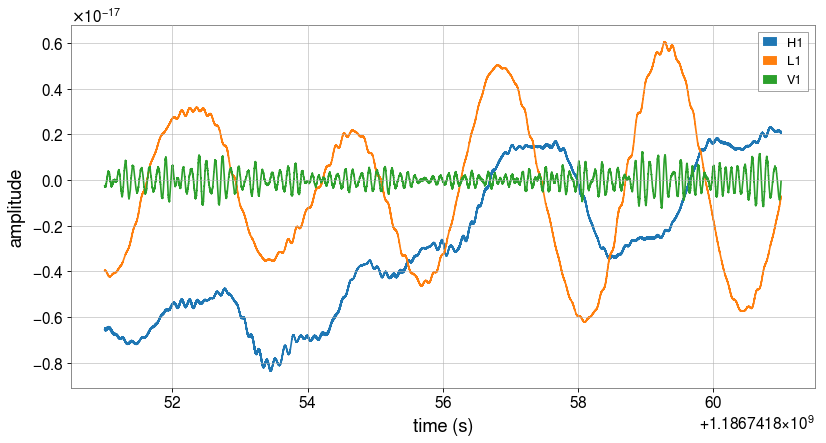

In [27]:
fig, axes = plt.subplots()
for h,d in zip(hoft,network): 
    plt.plot(h, label=d)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend(loc='upper right')
plt.show()

## Pre-process (high-pass)

In [29]:
preproc_f_cut = 5 # Hz
preproc_passband_db = 2 # dB
preproc_stopband_db = 10 # dB
hoft_preproc = [h.highpass(preproc_f_cut,gpass=preproc_passband_db, \
                           gstop=preproc_stopband_db,type='iir',filtfilt=True) for h in hoft]

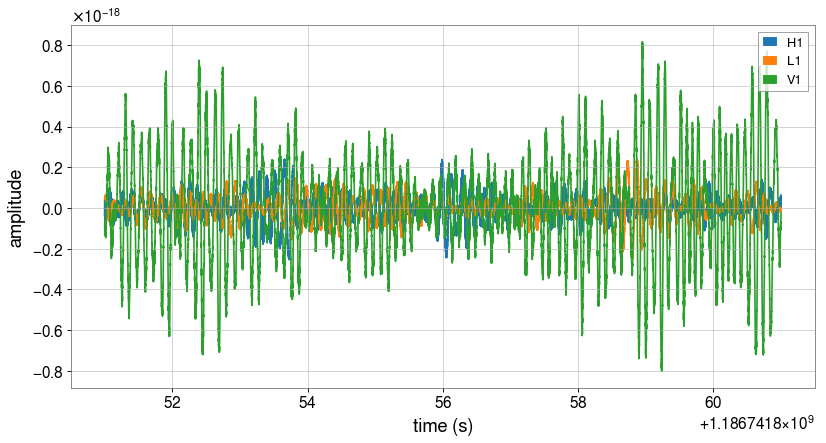

In [30]:
fig, axes = plt.subplots()
for h,d in zip(hoft_preproc,network): 
    plt.plot(h, label=d)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend(loc='upper right')
plt.show()

## Time frequency transforms

In [31]:
gabor = pb.timefreq.TimeFreqTransform("dgtreal", "hanning", 64, 512)
tfmaps = list(map(gabor.forward, hoft_preproc))

## Background spectrum estimate

In [32]:
strip_edge_size = 5
tfmaps_noiseonly = list(map(gabor.forward, data))
# XXX Use noiseonly tfmaps XXX
asds = numpy.array([tfmap.trim_edges(strip_edge_size).marginal(axis='freq') for tfmap in tfmaps_noiseonly])
# asds2 = [tfmap.trim_edges(strip_edge_size).marginal(axis='freq', method='mean') for tfmap in tfmaps_noiseonly]
freqs = numpy.array([tfmap.freqs(sampling_rate) for tfmap in tfmaps])

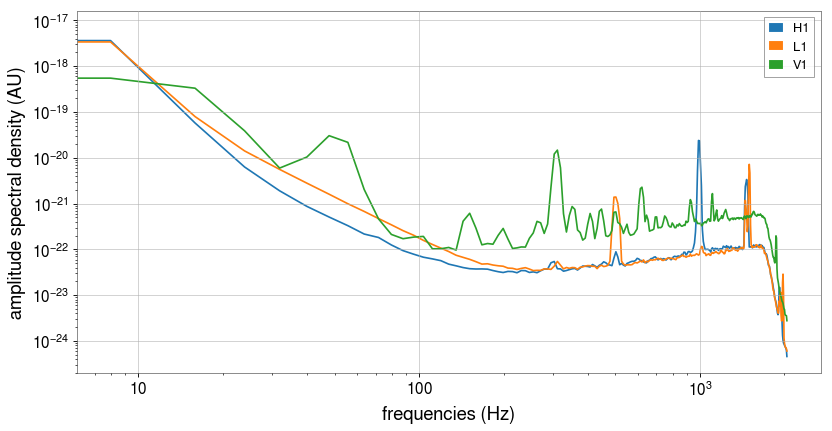

In [33]:
fig, axes = plt.subplots()
for f, asd, label in zip(freqs, asds, list(map(str, network))): 
    plt.loglog(f, asd, label=label)
    # plt.loglog(f, asd2, '--', label=label)

plt.xlabel('frequencies (Hz)')
plt.ylabel('amplitude spectral density (AU)')
plt.legend(loc='upper right')
plt.show()

## Whitening

In [34]:
lowf_cutoff = 25 # Hz
zero_edge_size = 5
whitened_tfmaps = numpy.array([tfmap.trim_edges(zero_edge_size,0).highpass(lowf_cutoff, sampling_rate).data \
                            / numpy.reshape(asd, (asd.size,1)) \
                            for tfmap, asd in zip(tfmaps, asds)])

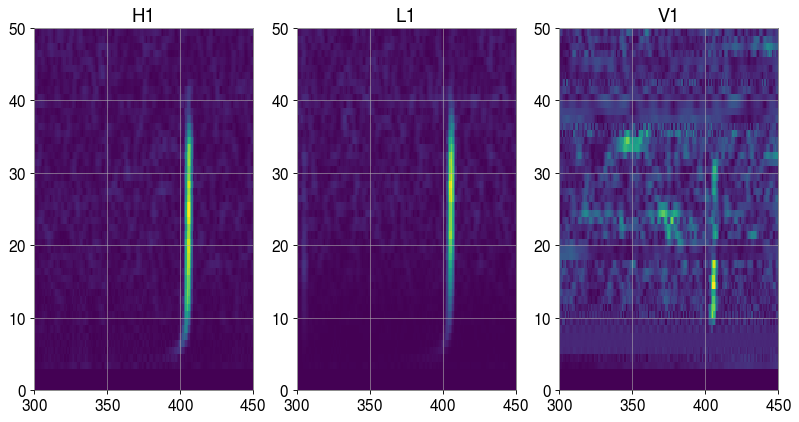

In [37]:
fig, axes = plt.subplots(1, len(network))
for ax, d, m in zip(axes, network, whitened_tfmaps):
    ax.pcolormesh(numpy.abs(m))
    ax.set_xlim([300,450])
    ax.set_ylim([0,50])
    ax.set_title(d)
plt.show()

## Main -- least square inversion

### Compute mixing matrix at each sky position and frequencies
Note: this can be done only once for an entire segment

#### Shapes of mixing matrices

Inputs:
* delays: Ndet x Nsky
* antenna_patterns: Ndet x Npol x Nsky
* asds: Ndet x Nfreq
* freqs: Ndet x Nfreq

Outputs:
* mixing_whitened: Nsky x Nfreq x Ndet x Npol
* mixing_whitened_inverse: Nsky x Nfreq x Npol x Ndet

Indices:
* s: index of sky pixel
* d: detector index
* p: polarization index (plus, cross)
* f: frequency index

In [42]:
# Is the sign in the phase correct?
phases = numpy.exp(-2*numpy.pi*1j* numpy.einsum('ds,df->sdf', delays, freqs))
mixing = numpy.einsum('dps,sdf->sfdp', antenna_patterns, phases)
mixing_whitened = numpy.einsum('dps,df,sdf->sfdp', antenna_patterns, 1/asds, phases)
mixing_whitened_inverse = numpy.linalg.pinv(mixing_whitened)

In [43]:
mixing_whitened = numpy.einsum('dps,df->sfdp', antenna_patterns, 1/asds)
mixing_whitened_inverse = numpy.linalg.pinv(mixing_whitened)

## Pixel selection

In [45]:
# Ad-hoc pixel selection for now
idx_time = numpy.arange(380,420, dtype=numpy.intp)
idx_freq = numpy.arange(3,50, dtype=numpy.intp)
cluster_ix = numpy.ix_(numpy.arange(3), idx_freq, idx_time)
reduced_tfmaps = whitened_tfmaps[cluster_ix]

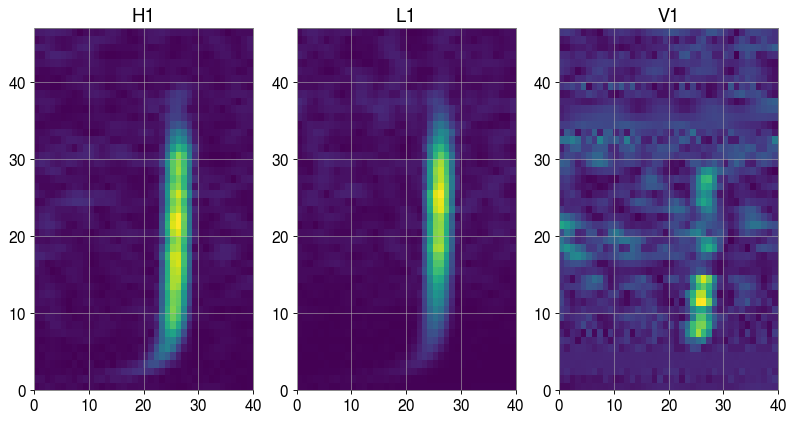

In [46]:
fig, axes = plt.subplots(1, len(network))
for ax, d, m in zip(axes, network, reduced_tfmaps):
    ax.pcolormesh(numpy.abs(m))
    ax.set_title(d)
plt.show()

Il faut trouver ici un moyen de reduire le nombre de pixels tout en preservant l'axe frequentiel
pour pouvoir continuer a appliquer la matrice de melange. Garder les indices temporels en memoire afin
de pouvoir reconstruire le signal ensuite.

Faire la selection en se basant seulement sur l'energie incoherente est probablement trop optimiste -- Perte de l'information de coincidence --> multiplication des clusters qui viennent du bruit

## Apply pseudo inverse to observations
Note: this produces an estimate of the signal time-frequency map assuming all source directions in the skygrid.
To save time, this could be done **only** on selected/clusterized pixels (above a certain threshold)

#### Shapes of matrices

Inputs:
* mixing_whitened: Nsky x Nfreq x Ndet x Npol
* mixing_whitened_inverse: Nsky x Nfreq x Npol x Ndet
* reduced_tfmaps: Ndet x Nfreq x Ntime

Outputs:
* signal_estimate_tfmaps: Nsky x Nfreq x Ntime x Npol
* response_estimate_tfmaps: Nsky x Ndet x Nfreq x Ntime

Indices:
* s: index of sky pixel
* d: detector index
* p: polarization index (plus, cross)
* f: frequency index

In [47]:
signal_estimate_tfmaps = numpy.einsum('sfpd,dft->sftp', mixing_whitened_inverse[:,idx_freq, ...], reduced_tfmaps)
response_estimate_tfmaps = numpy.einsum('sfdp,sftp->sdft', mixing_whitened[:,idx_freq, ...], signal_estimate_tfmaps)
estimation_error = numpy.linalg.norm(reduced_tfmaps[numpy.newaxis,:] \
                                    - response_estimate_tfmaps, \
                                         axis=(-2,-1)).sum(axis=-1)
skymap = sky.feed(estimation_error)

## Results and diagnosis plots

### Localization

In [48]:
injection_pt = pb.skymaps.Skypoint(numpy.radians(ra), numpy.radians(dec), \
                     'equatorial', 'injection')
print(injection_pt)

injection (equatorial): lon= +0.87266463 rad (  50.00 deg) lat= +0.87266463 rad (  50.00 deg)


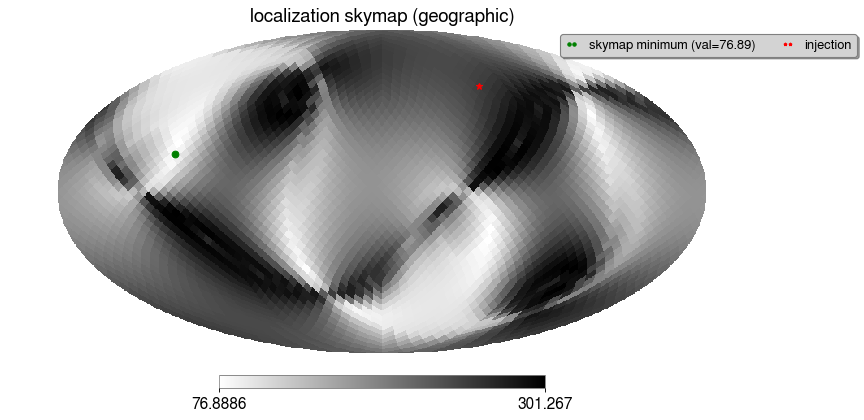

In [49]:
skymap.display("localization skymap")
skymap.argmin().display('o','g')
injection_pt.transformed_to('geographic', time).display('*','r')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1),
          ncol=2, fancybox=True, shadow=True, \
          facecolor="lightgray", markerscale = 0.5)
plt.show()

In [50]:
skymap_equatorial = skymap.transformed_to('equatorial', time)
leastsquare_pt = skymap_equatorial.argmin('leastsquare')
print(leastsquare_pt)

leastsquare (val=82.73) (equatorial): lon= +4.22151513 rad ( 241.88 deg) lat= +0.47611906 rad (  27.28 deg)


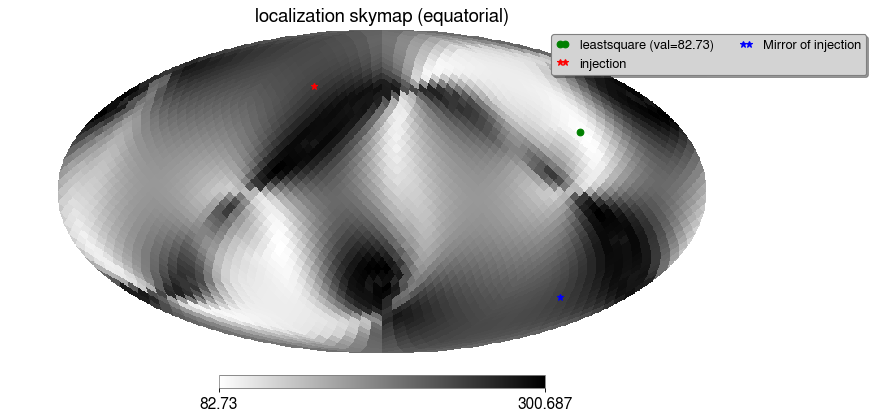

In [51]:
skymap_equatorial.display("localization skymap")
leastsquare_pt.display('o','g')
injection_pt.display('r','*')
injection_pt.mirror().display('b','*')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1),
            ncol=2, fancybox=True, shadow=True,\
            facecolor="lightgray", markerscale = 1)
plt.show()

296


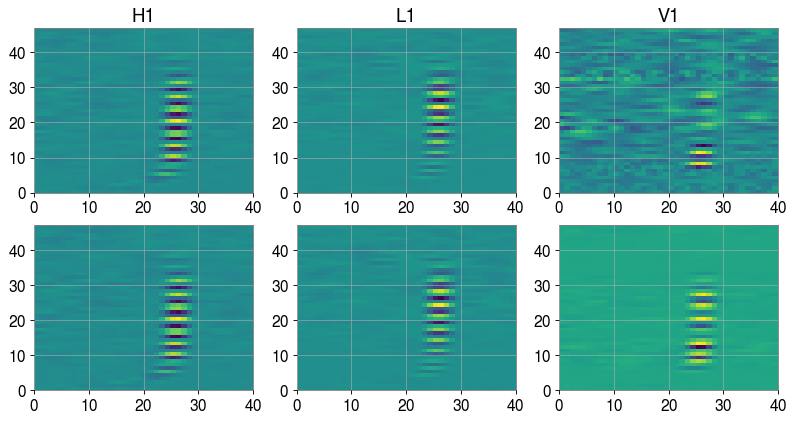

In [52]:
leastsquare_ix = estimation_error.argmin()
print(leastsquare_ix)
fig, axes = plt.subplots(2, len(network))
for n, d in enumerate(network):
    axes[0,n].pcolormesh(numpy.imag(reduced_tfmaps[n,...]))
    axes[0,n].set_title(d)
    axes[1,n].pcolormesh(numpy.imag(response_estimate_tfmaps[leastsquare_ix,n,...]))
plt.show()

reconstructed_responses = numpy.zeros_like(whitened_tfmaps)
print(reconstructed_responses[n,idx_freq,idx_time].shape)
print(response_estimate_tfmaps[leastsquare_ix,n,...].shape)
for n, d in enumerate(network):
    reconstructed_responses[n,idx_freq,idx_time] = response_estimate_tfmaps[leastsquare_ix,n,...]

## Ideas about pixel selection

In [ ]:
?numpy.empty_like